<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "8B"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/DissectionRegions/8B/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


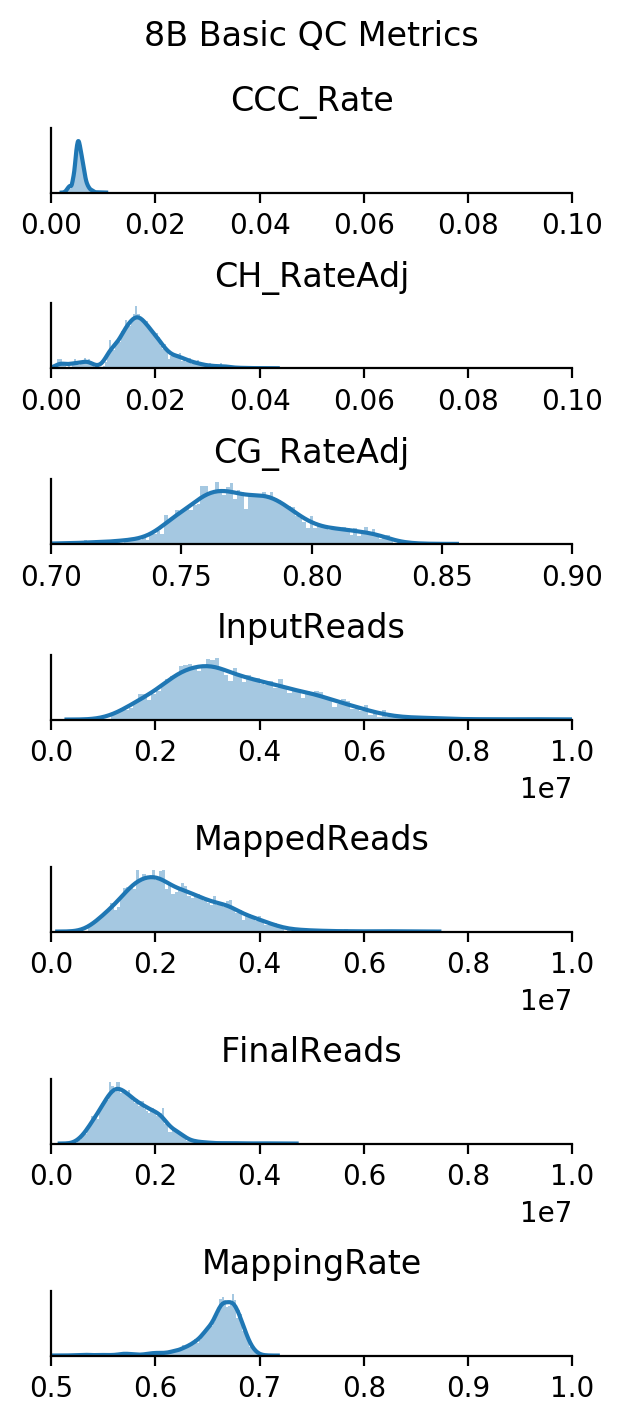

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

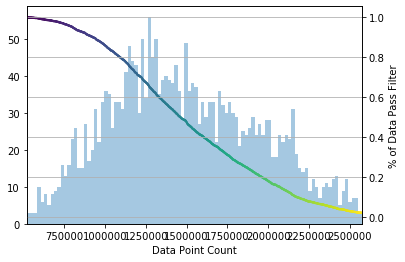

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 2474/2474 (100.0%)
CG_RateAdj passed 2474/2474 (100.0%)
CH_RateAdj passed 2474/2474 (100.0%)
FinalReads passed 2474/2474 (100.0%)
MappingRate passed 2474/2474 (100.0%)
Overall passed 2474/2474 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
180426 1266
180430 1208


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 309 80.5%
ad002 319 83.1%
ad004 311 81.0%
ad006 315 82.0%
ad007 307 79.9%
ad008 311 81.0%
ad010 304 79.2%
ad012 298 77.6%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,SubType,l3-umap_0,l3-umap_1,l3-tsne_0,l3-tsne_1,PassFilter
8B_M_0,/gale/raidix/rdx-4/mapping/8B/CEMBA180426-8B-1...,0.004766,0.779798,0.778743,0.019138,0.014441,2143587.0,5022018,3381664.0,8B,...,20.786003,5.491545,-47.904017,-8.140963,CT-L6 Megf9,-5.640281,-10.025516,-5.453386,25.365011,True
8B_M_1,/gale/raidix/rdx-4/mapping/8B/CEMBA180426-8B-1...,0.005008,0.780158,0.779052,0.020880,0.015952,1917019.0,4550670,3048508.0,8B,...,15.401173,-5.297118,8.844127,-11.644491,IT-L6 Man1c1,-8.038966,-5.881419,-1.148238,3.715338,True
8B_M_10,/gale/raidix/rdx-4/mapping/8B/CEMBA180426-8B-1...,0.005947,0.796720,0.795504,0.027763,0.021946,1141557.0,2544674,1627315.0,8B,...,13.371215,-13.306906,27.533679,25.564166,IT-L5 Grik3,10.281075,3.360658,-29.912590,13.305009,True
8B_M_100,/gale/raidix/rdx-4/mapping/8B/CEMBA180426-8B-1...,0.005993,0.774530,0.773171,0.027800,0.021939,2419045.0,5740530,3924171.0,8B,...,0.473631,-13.826750,-0.688130,35.734542,IT-L23 Cux1,-0.896394,6.277520,2.911143,-13.445560,True
8B_M_1000,/gale/raidix/rdx-4/mapping/8B/CEMBA180426-8B-3...,0.005995,0.802820,0.801631,0.026978,0.021110,1272590.0,2877948,1934409.0,8B,...,-26.408293,6.808690,12.983739,-32.930742,MGE-Pvalb Thsd7a,-4.873317,-5.017902,20.593557,-5.805386,True
8B_M_1001,/gale/raidix/rdx-4/mapping/8B/CEMBA180426-8B-3...,0.005106,0.765782,0.764580,0.021689,0.016668,805115.0,1857508,1216282.0,8B,...,0.434456,-13.669956,-3.378100,47.300895,IT-L23 Cux1,-2.210708,9.337178,-2.172652,-33.222716,True
8B_M_1002,/gale/raidix/rdx-4/mapping/8B/CEMBA180426-8B-3...,0.005238,0.761814,0.760560,0.024103,0.018964,594183.0,1561076,1068913.0,8B,...,-0.242282,-13.757318,-4.137697,49.528812,IT-L23 Cux1,-0.023860,8.919199,16.227873,-27.962397,True
8B_M_1003,/gale/raidix/rdx-4/mapping/8B/CEMBA180426-8B-3...,0.005142,0.762972,0.761747,0.023804,0.018759,2072887.0,5570960,3751159.0,8B,...,0.050895,-14.631055,-1.702885,53.125756,IT-L23 Cux1,-2.125126,9.734016,4.339742,-32.663939,True
8B_M_1004,/gale/raidix/rdx-4/mapping/8B/CEMBA180426-8B-3...,0.004456,0.786016,0.785058,0.018612,0.014220,2243564.0,5786356,4029540.0,8B,...,20.783447,7.132644,-44.014922,-28.652472,CT-L6 Il1rap,-7.624129,-15.822520,27.129823,6.728705,True
8B_M_1005,/gale/raidix/rdx-4/mapping/8B/CEMBA180426-8B-3...,0.004394,0.768025,0.767002,0.017003,0.012665,2044466.0,5486106,3735223.0,8B,...,-3.024881,-12.138112,-17.334449,57.051640,IT-L23 Cux1,5.597640,9.666664,40.027487,-28.766915,True
